In [103]:
import pandas as pd
import numpy as np
import joblib

df = pd.read_csv("finalNNDSS_new_1214_n.csv")
print('Disease Groups:')
print(df['Disease_group'].unique())

Disease Groups:
['Anthrax' 'Arboviral diseases' 'Candida auris' 'Hepatitis' 'Influenza'
 'Measles' 'Tuberculosis' 'Viral hemorrhagic fevers' 'Zika virus disease']


In [104]:
print('Features:')
print(df.columns)

Features:
Index(['Disease_group', 'Reporting Area norm', 'Current MMWR Year',
       'MMWR WEEK', 'Current week', 'current_week_reported', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_8', 'lag_12', 'lag_16', 'roll_mean_4',
       'roll_mean_8', 'roll_std_4', 'roll_std_8', 'growth_1', 'growth_4',
       'pct_change_1', 'pct_change_4', 'year', 'week', 'week_start_date',
       'month', 'quarter', 'day_of_year', 'season_winter', 'season_spring',
       'season_summer', 'season_fall', 'cases_prev', 'neighbor_cases_sum',
       'neighbor_cases_mean', 'neighbor_cases_max',
       'neighbor_states_reporting', 'log_population', 'log_density'],
      dtype='object')


In [105]:
df_flu = df[df["Disease_group"] == "Influenza"].copy()
df_flu = df_flu.sort_values(["Reporting Area norm", "year", "week"])
df_flu = df_flu.dropna()
df_flu = df_flu.reset_index(drop=True)
df_flu

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_spring,season_summer,season_fall,cases_prev,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Influenza,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
1,Influenza,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
2,Influenza,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
3,Influenza,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
4,Influenza,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Influenza,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9020,Influenza,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9021,Influenza,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9022,Influenza,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591


Total state-weeks: 9024
Positive state-weeks: 164
Percent positive: 1.817%


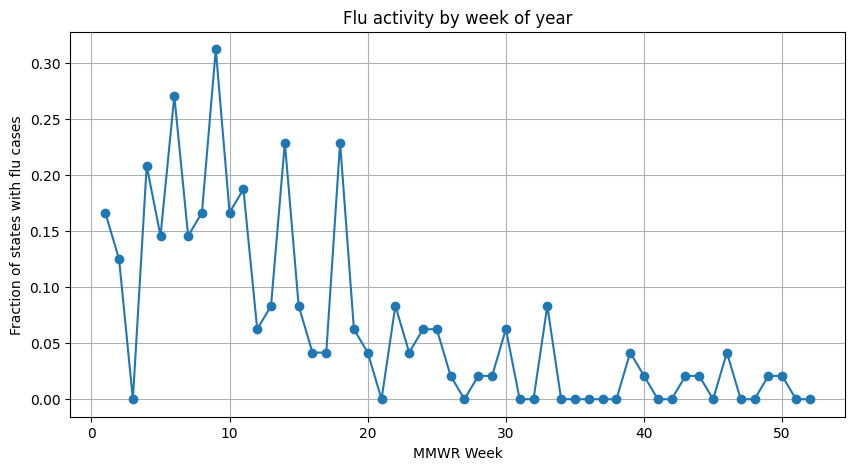

In [106]:
import matplotlib.pyplot as plt

total_rows = len(df_flu)
positive_rows = df_flu["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

weekly_pos = (
    df_flu
    .groupby("MMWR WEEK")["current_week_reported"]
    .sum()
    .reset_index(name="num_positive_states")
)

weekly_pos["percent_states_positive"] = (
    weekly_pos["num_positive_states"] /
    df_flu["Reporting Area norm"].nunique()
)

plt.figure(figsize=(10,5))
plt.plot(
    weekly_pos["MMWR WEEK"],
    weekly_pos["percent_states_positive"],
    marker="o"
)
plt.xlabel("MMWR Week")
plt.ylabel("Fraction of states with flu cases")
plt.title("Flu activity by week of year")
plt.grid(True)
plt.show()

In [107]:
# Create per-state time index
df_flu["t_idx"] = df_flu.groupby("Reporting Area norm").cumcount()
df_flu["t_len"] = df_flu.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_flu["is_train"] = df_flu["t_idx"] < (0.8 * df_flu["t_len"])

train_df = df_flu[df_flu["is_train"]].copy()
test_df  = df_flu[~df_flu["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [108]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * 2.6

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 138 neg: 7110 scale_pos_weight: 133.95652173913044


Accuracy: 0.8603603603603603, Precision: 0.9722739478356326, Recall: 0.8603603603603603, F1: 0.9117415801873802
Balanced Accuracy: 0.5313


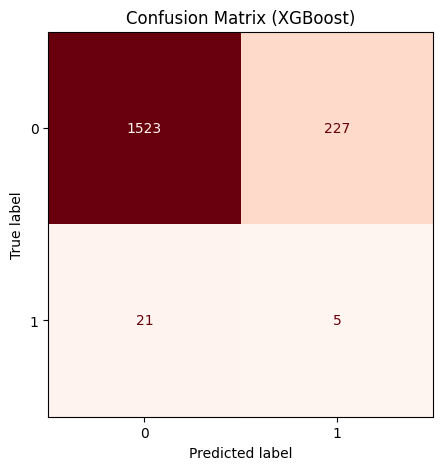

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      1750
           1       0.02      0.19      0.04        26

    accuracy                           0.86      1776
   macro avg       0.50      0.53      0.48      1776
weighted avg       0.97      0.86      0.91      1776



In [109]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, xgb_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Best threshold (Balanced Acc): 0.010
Balanced Acc: 0.7110
Recall(1) / TPR: 0.6923
Recall(0) / TNR: 0.7297
Accuracy: 0.7291666666666666, Precision: 0.9797625085521224, Recall: 0.8603603603603603, F1: 0.8302155594997966


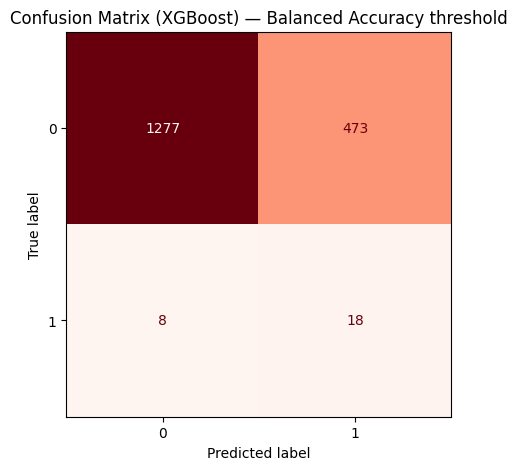

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1750
           1       0.04      0.69      0.07        26

    accuracy                           0.73      1776
   macro avg       0.52      0.71      0.46      1776
weighted avg       0.98      0.73      0.83      1776



In [110]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.740990990990991, Precision: 0.9806601567513235, Recall: 0.740990990990991, F1: 0.8380603601684388
Balanced Accuracy: 0.7360


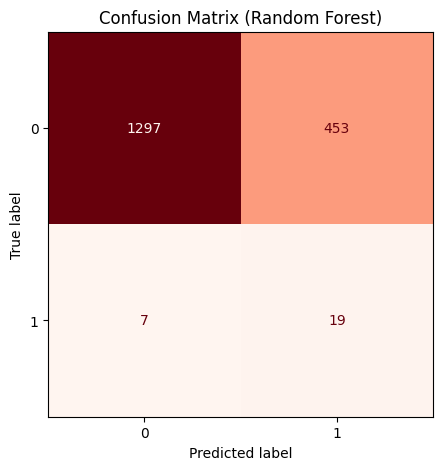

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1750
           1       0.04      0.73      0.08        26

    accuracy                           0.74      1776
   macro avg       0.52      0.74      0.46      1776
weighted avg       0.98      0.74      0.84      1776



['flu_clf_rf.joblib']

In [111]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos) * 2.6}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, rf_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

# Best performing model for flu, save it
joblib.dump(rf_clf, "flu_clf_rf.joblib")

In [112]:
# Regression models -> only on cases with positive reporting

df_flu_lin = df_flu.copy()
df_flu_lin = df_flu_lin[df_flu_lin["Current week"] > 0].copy()
df_flu_lin = df_flu_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_flu_lin["t_idx"] = df_flu_lin.groupby("Reporting Area norm").cumcount()
df_flu_lin["t_len"] = df_flu_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_flu_lin["is_train"] = df_flu_lin["t_idx"] < (0.8 * df_flu_lin["t_len"])

train_df = df_flu_lin[df_flu_lin["is_train"]].copy()
test_df  = df_flu_lin[~df_flu_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 0.8374
R²: -0.5435
RSS: 13.32
TSS: 8.63
ESS: 3.45


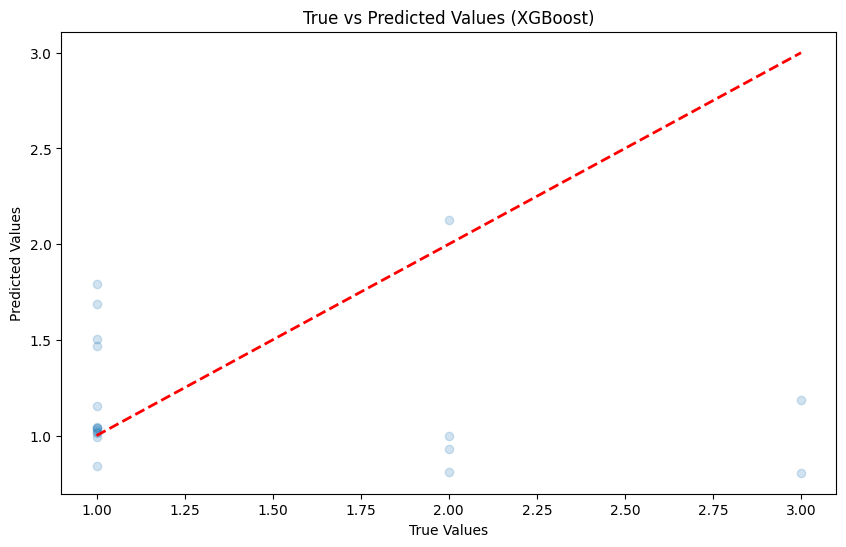

In [113]:
# XGBoost Regressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 0.7545
R²: -0.2530
RSS: 10.82
TSS: 8.63
ESS: 2.01


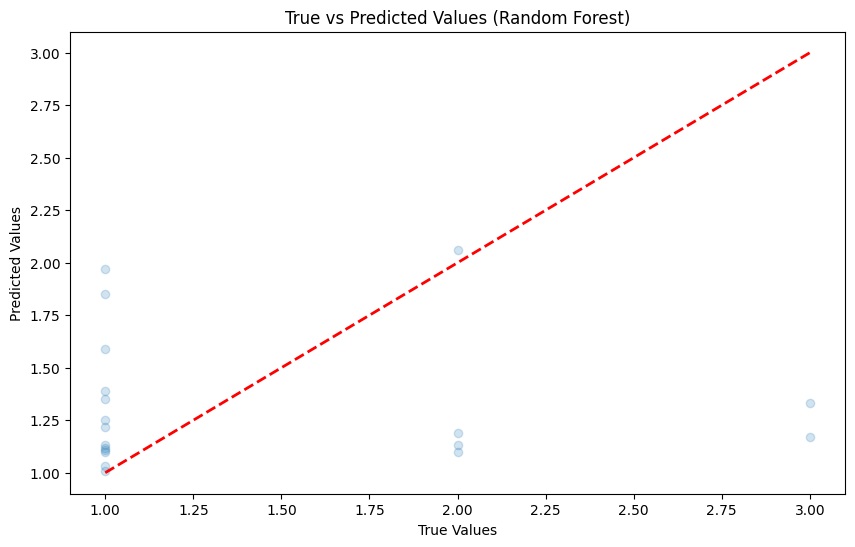

['flu_reg_rf.joblib']

In [114]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Best performing model for flu, save it
joblib.dump(rf, "flu_reg_rf.joblib")

alpha= 0.1: MAE=1.552, RMSE=1.798
alpha= 0.5: MAE=1.490, RMSE=1.715
alpha= 1.0: MAE=1.467, RMSE=1.676
alpha= 2.0: MAE=1.448, RMSE=1.645
alpha= 5.0: MAE=1.438, RMSE=1.617
alpha=10.0: MAE=1.428, RMSE=1.602
RMSE: 0.7545
R²: -0.2530
RSS: 10.82
TSS: 8.63
ESS: 2.01


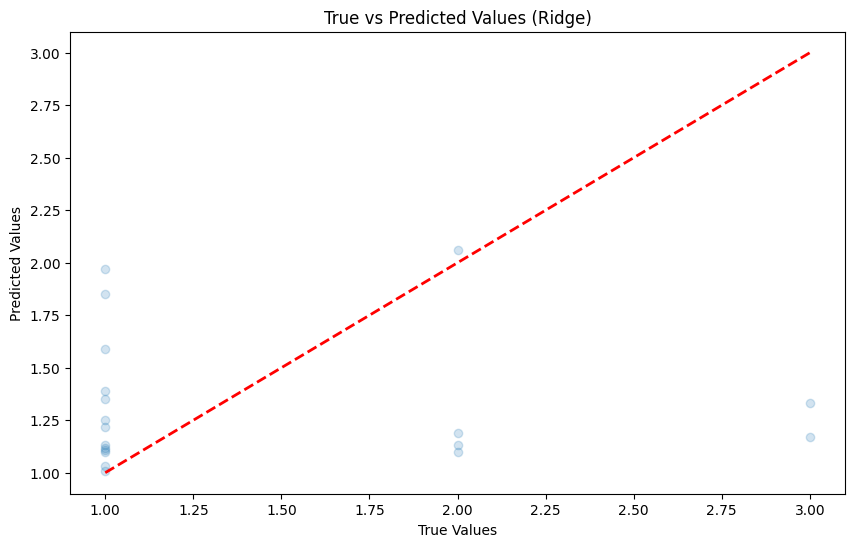

In [115]:
# Ridge Regressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

best_avg = 1000
best_alpha = -1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = (mae + rmse) / 2
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [116]:
# Measles
df_mea = df[df["Disease_group"] == "Measles"].copy()
df_mea = df_mea.sort_values(["Reporting Area norm", "year", "week"])
df_mea = df_mea.dropna()
df_mea = df_mea.reset_index(drop=True)
df_mea

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_spring,season_summer,season_fall,cases_prev,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Measles,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
1,Measles,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
2,Measles,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
3,Measles,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
4,Measles,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Measles,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591
9020,Measles,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591
9021,Measles,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591
9022,Measles,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,13.0,2.166667,13.0,1,13.277756,1.94591


In [117]:
total_rows = len(df_mea)
positive_rows = df_mea["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 204
Percent positive: 2.261%


In [118]:
# Create per-state time index
df_mea["t_idx"] = df_mea.groupby("Reporting Area norm").cumcount()
df_mea["t_len"] = df_mea.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_mea["is_train"] = df_mea["t_idx"] < (0.9 * df_mea["t_len"])

train_df = df_mea[df_mea["is_train"]].copy()
test_df  = df_mea[~df_mea["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [119]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * 50

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 156 neg: 8004 scale_pos_weight: 2565.3846153846152


Accuracy: 0.7454, Precision: 0.9263, Recall: 0.7454, F1: 0.8130
Balanced Accuracy: 0.6985


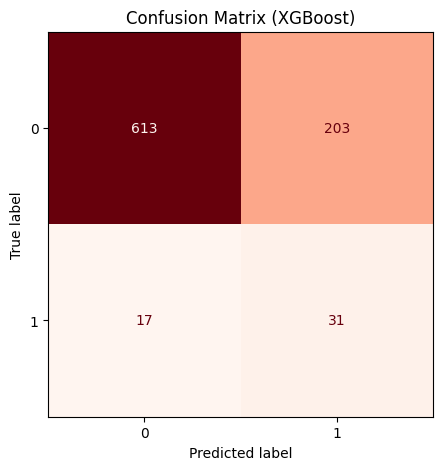

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       816
           1       0.13      0.65      0.22        48

    accuracy                           0.75       864
   macro avg       0.55      0.70      0.53       864
weighted avg       0.93      0.75      0.81       864



['mea_clf_xgb.joblib']

In [120]:
# Scale classifier to boost instances of reported cases
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, xgb_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

# Best performing model for measles (to get percent chance), save it
joblib.dump(xgb_clf, "mea_clf_xgb.joblib")

Best threshold (Balanced Acc): 0.020
Balanced Acc: 0.7996
Recall(1) / TPR: 0.7083
Recall(0) / TNR: 0.8909
Accuracy: 0.8808, Precision: 0.9420, Recall: 0.7454, F1: 0.9041


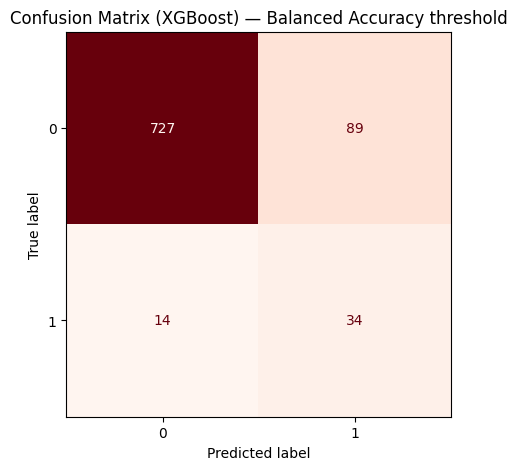

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       816
           1       0.28      0.71      0.40        48

    accuracy                           0.88       864
   macro avg       0.63      0.80      0.67       864
weighted avg       0.94      0.88      0.90       864



['mea_clf_xgb_noprob.joblib']

In [121]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

# Best performing model for measles, save it
joblib.dump(xgb_clf, "mea_clf_xgb_noprob.joblib")

Accuracy: 0.8865740740740741, Precision: 0.9088103254769921, Recall: 0.8865740740740741, F1: 0.8970702045328911
Balanced Accuracy: 0.5772


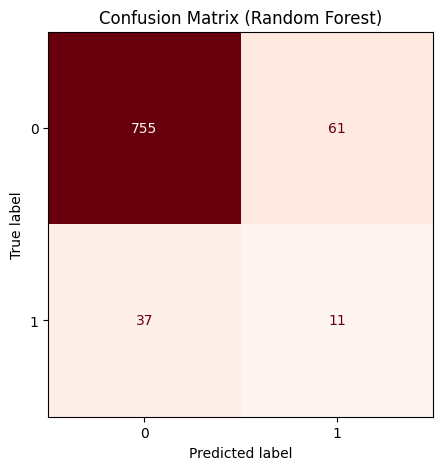

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       816
           1       0.15      0.23      0.18        48

    accuracy                           0.89       864
   macro avg       0.55      0.58      0.56       864
weighted avg       0.91      0.89      0.90       864



In [122]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos) * 4}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, rf_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

In [123]:
# Regression models -> only on cases with positive reporting

df_mea_lin = df_mea.copy()
df_mea_lin = df_mea_lin[df_mea_lin["Current week"] > 0].copy()
df_mea_lin = df_mea_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_mea_lin["t_idx"] = df_mea_lin.groupby("Reporting Area norm").cumcount()
df_mea_lin["t_len"] = df_mea_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_mea_lin["is_train"] = df_mea_lin["t_idx"] < (0.8 * df_mea_lin["t_len"])

train_df = df_mea_lin[df_mea_lin["is_train"]].copy()
test_df  = df_mea_lin[~df_mea_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 3.6449
R²: 0.0211
RSS: 411.85
TSS: 420.71
ESS: 73.28


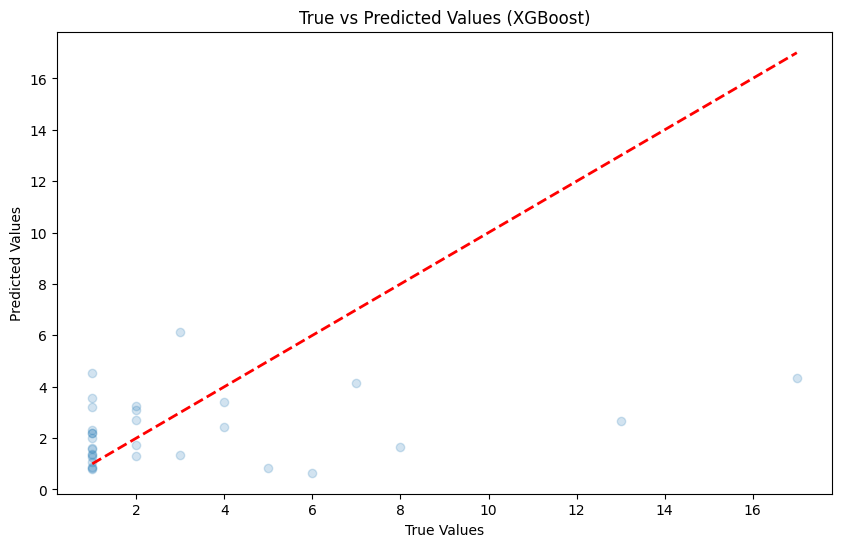

In [124]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 3.3021
R²: 0.1966
RSS: 338.01
TSS: 420.71
ESS: 67.42


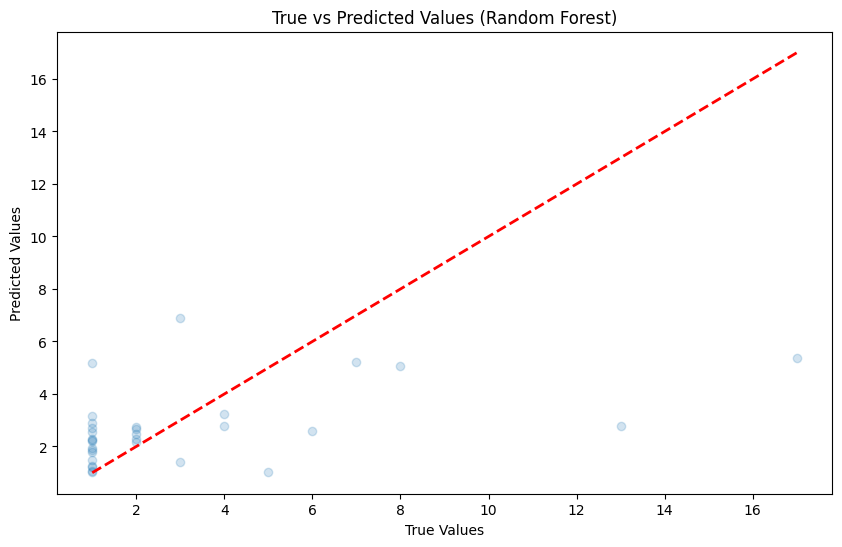

['mea_lin_rf.joblib']

In [125]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Best performing model for measles, save it
joblib.dump(rf, "mea_lin_rf.joblib")

alpha= 0.1: MAE=80.240, RMSE=322.503
alpha= 0.5: MAE=60.852, RMSE=215.999
alpha= 1.0: MAE=52.710, RMSE=160.075
alpha= 2.0: MAE=52.912, RMSE=116.619
alpha= 5.0: MAE=144.753, RMSE=476.724
alpha=10.0: MAE=213.730, RMSE=713.134
RMSE: 3.3021
R²: 0.1966
RSS: 338.01
TSS: 420.71
ESS: 67.42


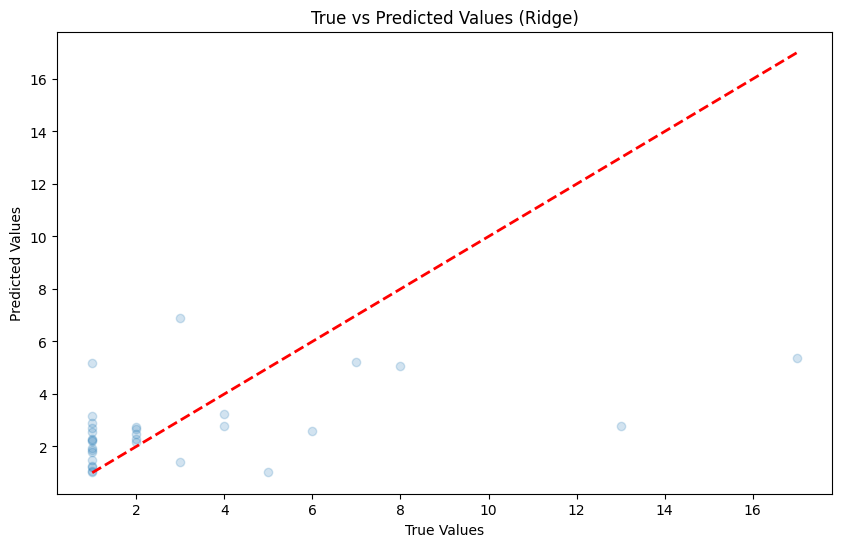

In [126]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

best_avg = 1000
best_alpha = -1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = (mae + rmse) / 2
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [127]:
# Anthrax
df_ant = df[df["Disease_group"] == "Anthrax"].copy()
df_ant = df_ant.sort_values(["Reporting Area norm", "year", "week"])
df_ant = df_ant.dropna()
df_ant = df_ant.reset_index(drop=True)
df_ant

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_spring,season_summer,season_fall,cases_prev,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Anthrax,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
1,Anthrax,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
2,Anthrax,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
3,Anthrax,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
4,Anthrax,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Anthrax,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9020,Anthrax,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9021,Anthrax,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9022,Anthrax,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591


In [128]:
total_rows = len(df_ant)
positive_rows = df_ant["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

# No positive cases of anthrax in mainland US

Total state-weeks: 9024
Positive state-weeks: 0
Percent positive: 0.000%


In [129]:
# Arboviral diseases
df_arb = df[df["Disease_group"] == "Arboviral diseases"].copy()
df_arb = df_arb.sort_values(["Reporting Area norm", "year", "week"])
df_arb = df_arb.dropna()
df_arb = df_arb.reset_index(drop=True)
df_arb

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_spring,season_summer,season_fall,cases_prev,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Arboviral diseases,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
1,Arboviral diseases,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
2,Arboviral diseases,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
3,Arboviral diseases,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
4,Arboviral diseases,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Arboviral diseases,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591
9020,Arboviral diseases,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591
9021,Arboviral diseases,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,1.0,0.166667,1.0,1,13.277756,1.94591
9022,Arboviral diseases,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591


In [130]:
total_rows = len(df_arb)
positive_rows = df_arb["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 339
Percent positive: 3.757%


In [131]:
# Create per-state time index
df_arb["t_idx"] = df_arb.groupby("Reporting Area norm").cumcount()
df_arb["t_len"] = df_arb.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_arb["is_train"] = df_arb["t_idx"] < (0.8 * df_arb["t_len"])

train_df = df_arb[df_arb["is_train"]].copy()
test_df  = df_arb[~df_arb["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [132]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * 2

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 231 neg: 7017 scale_pos_weight: 60.753246753246756


Accuracy: 0.8063, Precision: 0.9468, Recall: 0.8063, F1: 0.8541
Balanced Accuracy: 0.8579


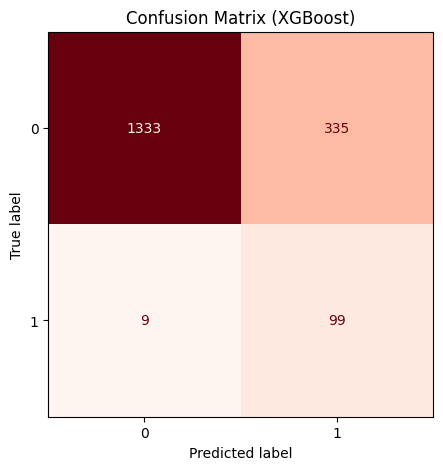

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      1668
           1       0.23      0.92      0.37       108

    accuracy                           0.81      1776
   macro avg       0.61      0.86      0.63      1776
weighted avg       0.95      0.81      0.85      1776



In [133]:
# Scale classifier to boost instances of reported cases
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, xgb_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Best threshold (Balanced Acc): 0.050
Balanced Acc: 0.8715
Recall(1) / TPR: 0.8426
Recall(0) / TNR: 0.9005
Accuracy: 0.8970, Precision: 0.9502, Recall: 0.8063, F1: 0.9156


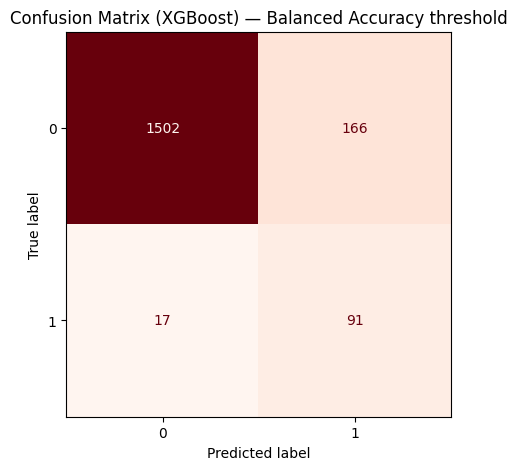

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1668
           1       0.35      0.84      0.50       108

    accuracy                           0.90      1776
   macro avg       0.67      0.87      0.72      1776
weighted avg       0.95      0.90      0.92      1776



['arb_clf_xgb_noprob.joblib']

In [134]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

# Best performing model for arborviral, save it
joblib.dump(xgb_clf, "arb_clf_xgb_noprob.joblib")

Balanced Accuracy: 0.8621
Accuracy: 0.8873873873873874, Precision: 0.9480701172073199, Recall: 0.8873873873873874, F1: 0.9087768328493091


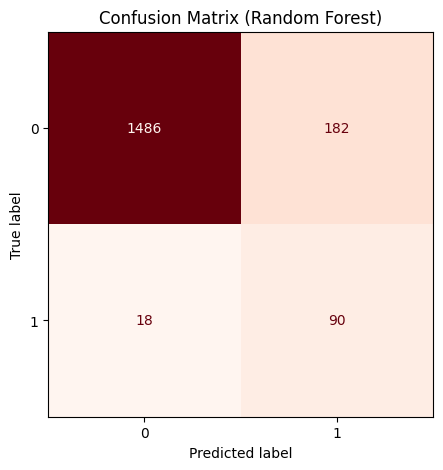

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1668
           1       0.33      0.83      0.47       108

    accuracy                           0.89      1776
   macro avg       0.66      0.86      0.71      1776
weighted avg       0.95      0.89      0.91      1776



['arb_clf_rf.joblib']

In [135]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos) * 1.25}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, rf_preds):.4f}")
print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

# Best performing model for arborviral, save it
joblib.dump(rf_clf, "arb_clf_rf.joblib")

In [136]:
# Regression models -> only on cases with positive reporting

df_arb_lin = df_arb.copy()
df_arb_lin = df_arb_lin[df_arb_lin["Current week"] > 0].copy()
df_arb_lin = df_arb_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_arb_lin["t_idx"] = df_arb_lin.groupby("Reporting Area norm").cumcount()
df_arb_lin["t_len"] = df_arb_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_arb_lin["is_train"] = df_arb_lin["t_idx"] < (0.8 * df_arb_lin["t_len"])

train_df = df_arb_lin[df_arb_lin["is_train"]].copy()
test_df  = df_arb_lin[~df_arb_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 4.1476
R²: 0.2109
RSS: 997.74
TSS: 1264.48
ESS: 101.66


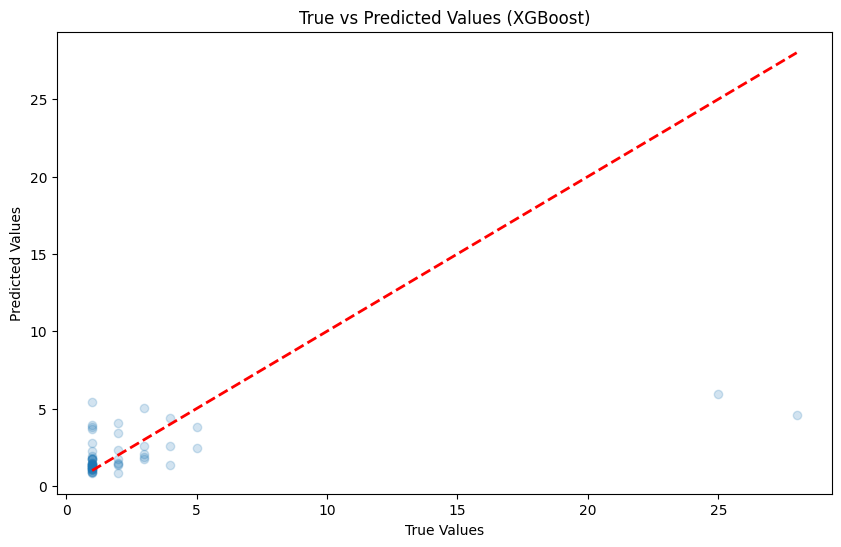

In [137]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 4.0277
R²: 0.2559
RSS: 940.90
TSS: 1264.48
ESS: 117.14


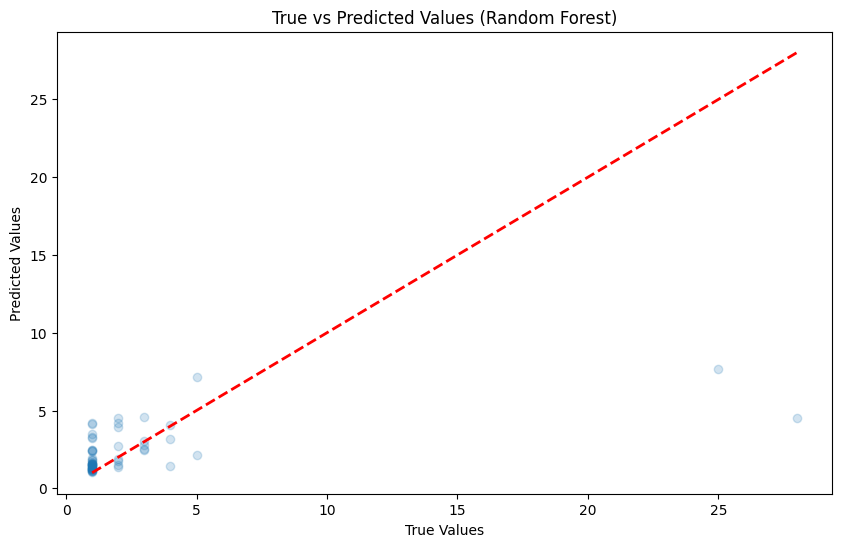

['arb_lin_rf.joblib']

In [138]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Best performing model for arborviral, save it
joblib.dump(rf, "arb_lin_rf.joblib")

alpha= 0.1: MAE=3000.033, RMSE=22336.175
alpha= 0.5: MAE=3182.089, RMSE=23720.585
alpha= 1.0: MAE=3400.450, RMSE=25369.176
alpha= 2.0: MAE=3724.368, RMSE=27803.426
alpha= 5.0: MAE=4250.476, RMSE=31700.825
alpha=10.0: MAE=4594.193, RMSE=34114.706
RMSE: 4.0277
R²: 0.2559
RSS: 940.90
TSS: 1264.48
ESS: 117.14


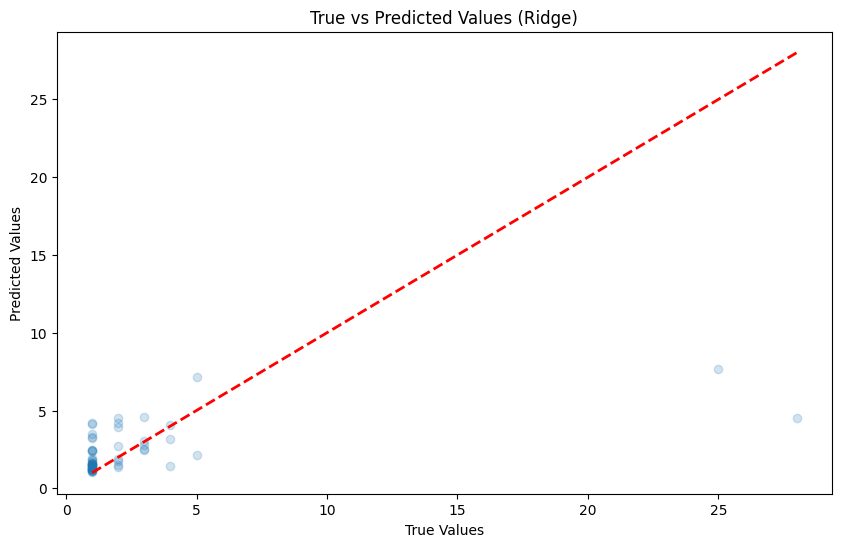

In [139]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

best_avg = 100000
best_alpha = -1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = (mae + rmse) / 2
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [140]:
# Candida auris
df_can = df[df["Disease_group"] == "Candida auris"].copy()
df_can = df_can.sort_values(["Reporting Area norm", "year", "week"])
df_can = df_can.dropna()
df_can = df_can.reset_index(drop=True)
df_can

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_spring,season_summer,season_fall,cases_prev,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Candida auris,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
1,Candida auris,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
2,Candida auris,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
3,Candida auris,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
4,Candida auris,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.000000,0.0,0,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Candida auris,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591
9020,Candida auris,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591
9021,Candida auris,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,1.0,0.166667,1.0,1,13.277756,1.94591
9022,Candida auris,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591


In [141]:
total_rows = len(df_can)
positive_rows = df_can["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 1307
Percent positive: 14.484%


In [142]:
# Create per-state time index
df_can["t_idx"] = df_can.groupby("Reporting Area norm").cumcount()
df_can["t_len"] = df_can.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_can["is_train"] = df_can["t_idx"] < (0.8 * df_can["t_len"])

train_df = df_can[df_can["is_train"]].copy()
test_df  = df_can[~df_can["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [143]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * .5

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 924 neg: 6324 scale_pos_weight: 3.4220779220779223


Accuracy: 0.9347, Precision: 0.9343, Recall: 0.9347, F1: 0.9345
Balanced Accuracy: 0.9006


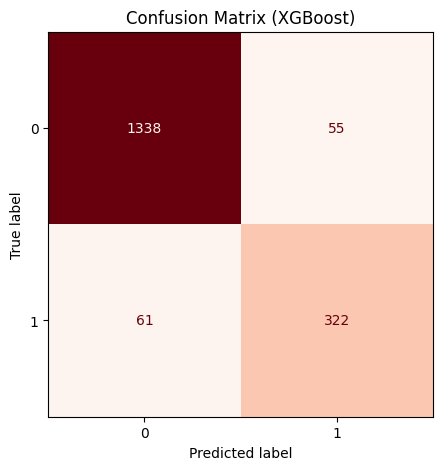

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1393
           1       0.85      0.84      0.85       383

    accuracy                           0.93      1776
   macro avg       0.91      0.90      0.90      1776
weighted avg       0.93      0.93      0.93      1776



In [144]:
# Scale classifier to boost instances of reported cases -> don't need to scale
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    #scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, xgb_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Best threshold (Balanced Acc): 0.190
Balanced Acc: 0.9223
Recall(1) / TPR: 0.9164
Recall(0) / TNR: 0.9282
Accuracy: 0.9257, Precision: 0.9332, Recall: 0.9347, F1: 0.9278


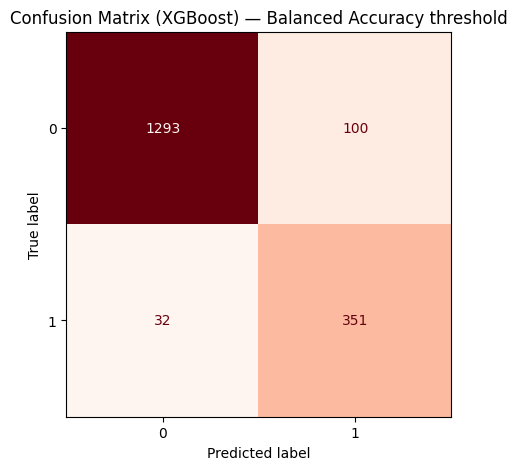

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1393
           1       0.78      0.92      0.84       383

    accuracy                           0.93      1776
   macro avg       0.88      0.92      0.90      1776
weighted avg       0.93      0.93      0.93      1776



In [145]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.9161036036036037, Precision: 0.9297345437798927, Recall: 0.9161036036036037, F1: 0.9194123629148082
Balanced Accuracy: 0.9238


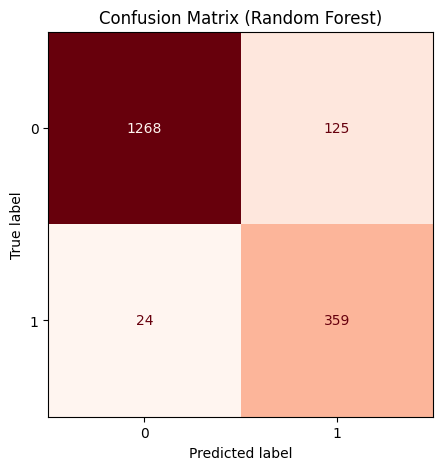

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1393
           1       0.74      0.94      0.83       383

    accuracy                           0.92      1776
   macro avg       0.86      0.92      0.89      1776
weighted avg       0.93      0.92      0.92      1776



['can_clf_rf.joblib']

In [146]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos)}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, rf_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

# Best performing model for candida auris, save it (negligible difference with threshold changing)
joblib.dump(rf_clf, "can_clf_rf.joblib")

In [147]:
# Regression models -> all cases, there is enough support now

df_can_lin = df_can.copy()
df_can_lin = df_can_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_can_lin["t_idx"] = df_can_lin.groupby("Reporting Area norm").cumcount()
df_can_lin["t_len"] = df_can_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_can_lin["is_train"] = df_can_lin["t_idx"] < (0.8 * df_can_lin["t_len"])

train_df = df_can_lin[df_can_lin["is_train"]].copy()
test_df  = df_can_lin[~df_can_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 4.3314
R²: 0.4950
RSS: 33320.31
TSS: 65976.59
ESS: 29451.66


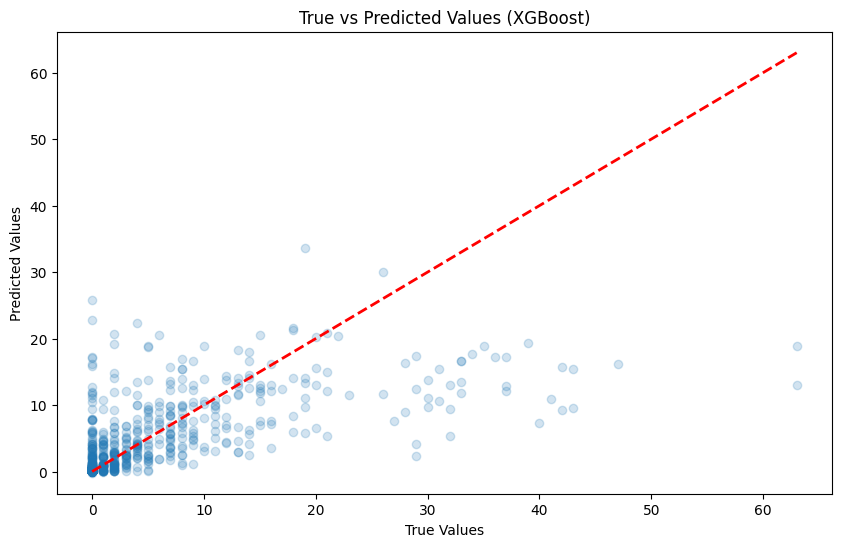

In [148]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 3.9763
R²: 0.5744
RSS: 28080.19
TSS: 65976.59
ESS: 36755.09


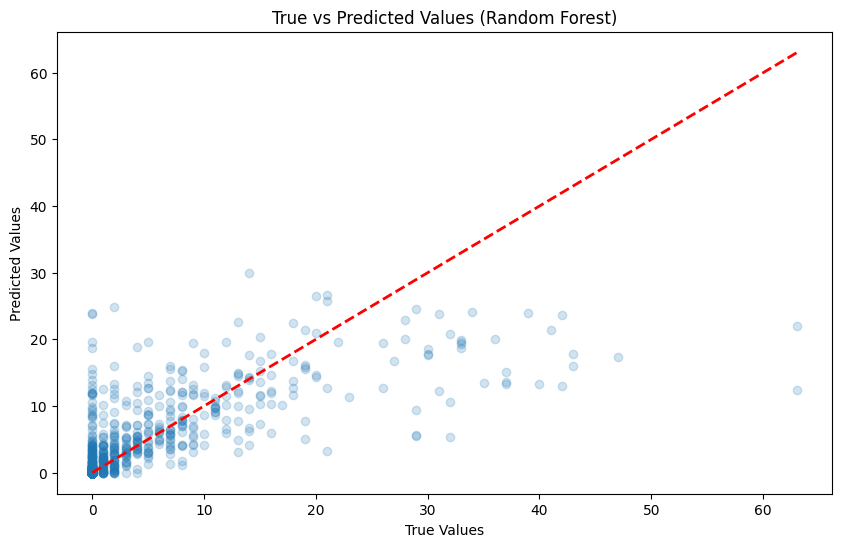

['can_lin_rf.joblib']

In [149]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Best performing model for candida auris, save it
joblib.dump(rf, "can_lin_rf.joblib")

alpha= 0.1: MAE=883024881300875.875, RMSE=37025927316030880.000
alpha= 0.5: MAE=876878037909148.500, RMSE=36764014431126696.000
alpha= 1.0: MAE=869318951217020.125, RMSE=36442139318171912.000
alpha= 2.0: MAE=854591684082991.000, RMSE=35815700688152068.000
alpha= 5.0: MAE=813186346365886.500, RMSE=34058971042207680.000
alpha=10.0: MAE=751851443612820.625, RMSE=31467195531953336.000
RMSE: 3.9763
R²: 0.5744
RSS: 28080.19
TSS: 65976.59
ESS: 36755.09


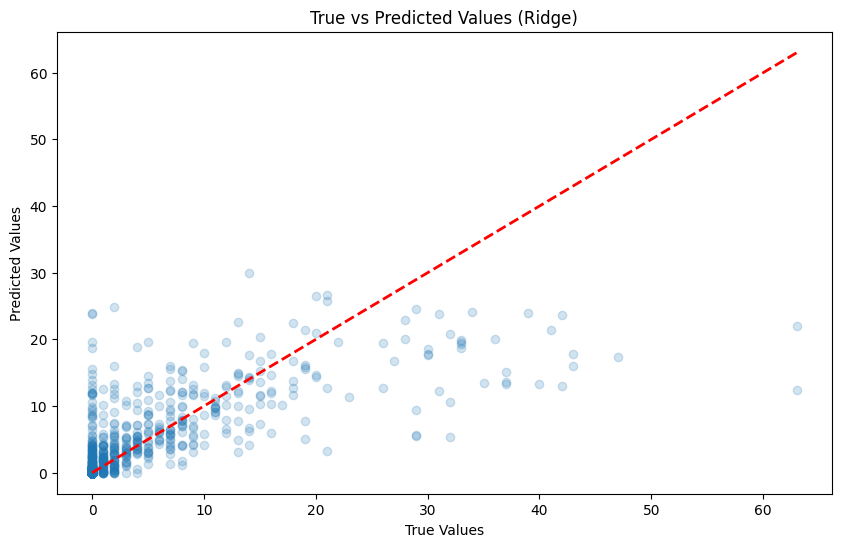

In [150]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

best_avg = 10000000000000000000
best_alpha = -1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = (mae + rmse) / 2
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [151]:
# Hepatitis
df_hep = df[df["Disease_group"] == "Hepatitis"].copy()
df_hep = df_hep.sort_values(["Reporting Area norm", "year", "week"])
df_hep = df_hep.dropna()
df_hep = df_hep.reset_index(drop=True)
df_hep

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_spring,season_summer,season_fall,cases_prev,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Hepatitis,Alabama,2022,17,0.0,0,2.0,0.0,0.0,1.0,...,1,0,0,2.0,50.0,12.500000,46.0,3,15.439699,4.60517
1,Hepatitis,Alabama,2022,18,0.0,0,0.0,2.0,0.0,0.0,...,1,0,0,0.0,54.0,13.500000,45.0,4,15.439699,4.60517
2,Hepatitis,Alabama,2022,19,1.0,1,0.0,0.0,2.0,0.0,...,1,0,0,0.0,62.0,15.500000,59.0,3,15.439699,4.60517
3,Hepatitis,Alabama,2022,20,0.0,0,1.0,0.0,0.0,2.0,...,1,0,0,1.0,36.0,9.000000,31.0,3,15.439699,4.60517
4,Hepatitis,Alabama,2022,21,0.0,0,0.0,1.0,0.0,0.0,...,1,0,0,0.0,6.0,1.500000,3.0,3,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Hepatitis,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,134.0,22.333333,85.0,5,13.277756,1.94591
9020,Hepatitis,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,130.0,21.666667,75.0,5,13.277756,1.94591
9021,Hepatitis,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,139.0,23.166667,89.0,5,13.277756,1.94591
9022,Hepatitis,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,142.0,23.666667,84.0,5,13.277756,1.94591


In [152]:
total_rows = len(df_hep)
positive_rows = df_hep["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 4638
Percent positive: 51.396%


In [153]:
# Create per-state time index
df_hep["t_idx"] = df_hep.groupby("Reporting Area norm").cumcount()
df_hep["t_len"] = df_hep.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_hep["is_train"] = df_hep["t_idx"] < (0.8 * df_hep["t_len"])

train_df = df_hep[df_hep["is_train"]].copy()
test_df  = df_hep[~df_hep["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [154]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * .5

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 3461 neg: 3787 scale_pos_weight: 0.5470962149667726


Accuracy: 0.9082, Precision: 0.9083, Recall: 0.9082, F1: 0.9083
Balanced Accuracy: 0.8980


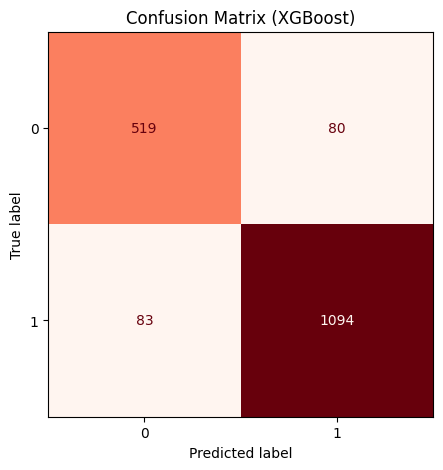

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       599
           1       0.93      0.93      0.93      1177

    accuracy                           0.91      1776
   macro avg       0.90      0.90      0.90      1776
weighted avg       0.91      0.91      0.91      1776



['hep_clf_xgb.joblib']

In [155]:
# Scale classifier to boost instances of reported cases -> don't need to scale
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    #scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, xgb_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

# Best performing model for hepatitis, save it (negligibl with threshold changing)
joblib.dump(xgb_clf, "hep_clf_xgb.joblib")

Best threshold (Balanced Acc): 0.640
Balanced Acc: 0.9061
Recall(1) / TPR: 0.9057
Recall(0) / TNR: 0.9065
Accuracy: 0.9060, Precision: 0.9097, Recall: 0.9082, F1: 0.9069


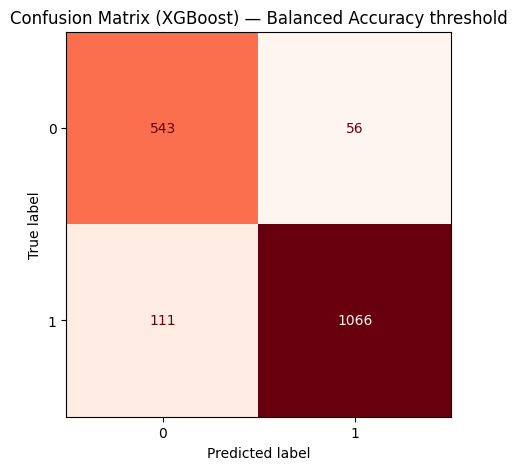

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       599
           1       0.95      0.91      0.93      1177

    accuracy                           0.91      1776
   macro avg       0.89      0.91      0.90      1776
weighted avg       0.91      0.91      0.91      1776



In [156]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.9042792792792793, Precision: 0.9041310148335601, Recall: 0.9042792792792793, F1: 0.904200131121954
Balanced Accuracy: 0.8921


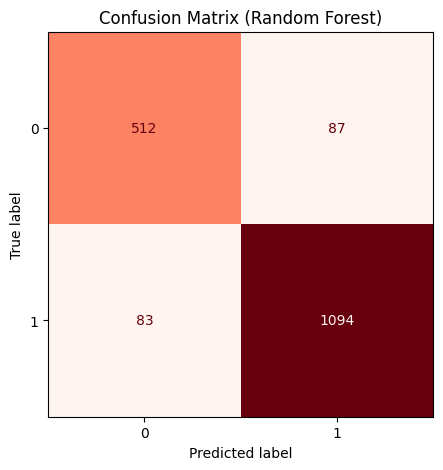

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       599
           1       0.93      0.93      0.93      1177

    accuracy                           0.90      1776
   macro avg       0.89      0.89      0.89      1776
weighted avg       0.90      0.90      0.90      1776



In [157]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    #class_weight={0: 1, 1: (neg / pos)}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, rf_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

In [158]:
# Regression models -> all cases, there is enough support

df_hep_lin = df_hep.copy()
df_hep_lin = df_hep_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_hep_lin["t_idx"] = df_hep_lin.groupby("Reporting Area norm").cumcount()
df_hep_lin["t_len"] = df_hep_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_hep_lin["is_train"] = df_hep_lin["t_idx"] < (0.8 * df_hep_lin["t_len"])

train_df = df_hep_lin[df_hep_lin["is_train"]].copy()
test_df  = df_hep_lin[~df_hep_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 27.3481
R²: 0.8511
RSS: 1328300.07
TSS: 8919704.68
ESS: 7753128.48


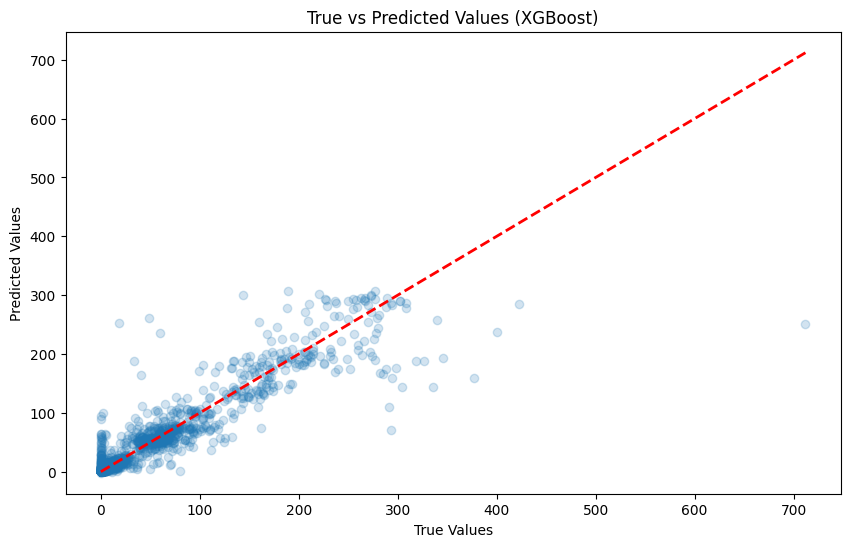

In [159]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 26.0752
R²: 0.8646
RSS: 1207526.71
TSS: 8919704.68
ESS: 7647252.76


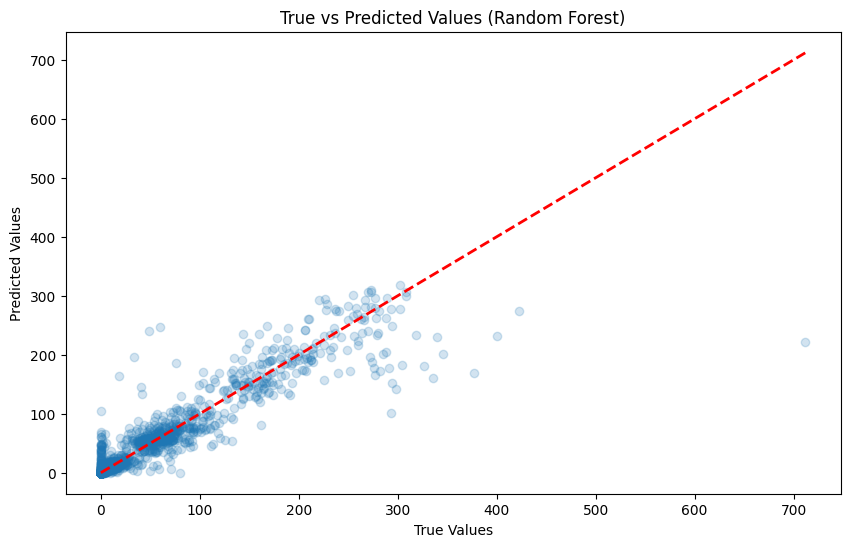

['hep_lin_rf.joblib']

In [160]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Best performing model for hepatitis, save it
joblib.dump(rf, "hep_lin_rf.joblib")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0

alpha= 0.1: MAE=751851443612820.625, RMSE=inf
alpha= 0.5: MAE=751851443612820.625, RMSE=inf
alpha= 1.0: MAE=751851443612820.625, RMSE=inf
alpha= 2.0: MAE=751851443612820.625, RMSE=inf
alpha= 5.0: MAE=751851443612820.625, RMSE=inf
alpha=10.0: MAE=751851443612820.625, RMSE=inf
RMSE: 26.0752
R²: 0.8646
RSS: 1207526.71
TSS: 8919704.68
ESS: 7647252.76


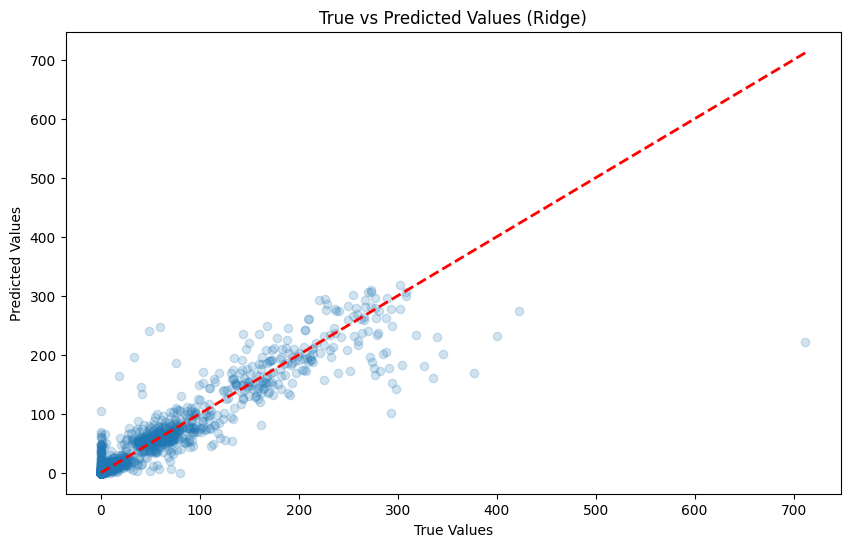

In [161]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

ridge = Ridge(alpha=0.1, random_state=42)
ridge.fit(X_train_s, y_train)
y_pred = np.expm1(ridge.predict(X_test_s))
rmse = sqrt(mean_squared_error(y_test, y_pred))
best_avg = rmse
best_alpha = 0.1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = rmse
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [162]:
# Tuberculosis
df_tub = df[df["Disease_group"] == "Tuberculosis"].copy()
df_tub = df_tub.sort_values(["Reporting Area norm", "year", "week"])
df_tub = df_tub.dropna()
df_tub = df_tub.reset_index(drop=True)
df_tub

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_spring,season_summer,season_fall,cases_prev,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Tuberculosis,Alabama,2022,17,1.0,1,2.0,1.0,0.0,5.0,...,1,0,0,2.0,3.0,0.750000,3.0,1,15.439699,4.60517
1,Tuberculosis,Alabama,2022,18,1.0,1,1.0,2.0,1.0,0.0,...,1,0,0,1.0,7.0,1.750000,7.0,1,15.439699,4.60517
2,Tuberculosis,Alabama,2022,19,1.0,1,1.0,1.0,2.0,1.0,...,1,0,0,1.0,5.0,1.250000,4.0,2,15.439699,4.60517
3,Tuberculosis,Alabama,2022,20,0.0,0,1.0,1.0,1.0,2.0,...,1,0,0,1.0,4.0,1.000000,4.0,1,15.439699,4.60517
4,Tuberculosis,Alabama,2022,21,1.0,1,0.0,1.0,1.0,1.0,...,1,0,0,0.0,4.0,1.000000,4.0,1,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Tuberculosis,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,1.0,0.166667,1.0,1,13.277756,1.94591
9020,Tuberculosis,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591
9021,Tuberculosis,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,2.0,0.333333,1.0,2,13.277756,1.94591
9022,Tuberculosis,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.000000,0.0,0,13.277756,1.94591


In [163]:
total_rows = len(df_tub)
positive_rows = df_tub["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

Total state-weeks: 9024
Positive state-weeks: 2430
Percent positive: 26.928%


In [164]:
# Create per-state time index
df_tub["t_idx"] = df_tub.groupby("Reporting Area norm").cumcount()
df_tub["t_len"] = df_tub.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

# 80/20 split per state
df_tub["is_train"] = df_tub["t_idx"] < (0.8 * df_tub["t_len"])

train_df = df_tub[df_tub["is_train"]].copy()
test_df  = df_tub[~df_tub["is_train"]].copy()

exclude_cols = {
    "Disease_group",
    "Current MMWR Year",
    "year",
    "week",
    "Reporting Area norm",
    "Current week",
    "current_week_reported",
    "week_start_date",
    "is_train",
    "t_idx",
    "t_len"
}

feature_cols = [c for c in df_flu.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["current_week_reported"]

X_test  = test_df[feature_cols]
y_test  = test_df["current_week_reported"]

In [165]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) * .75

print("pos:", pos, "neg:", neg, "scale_pos_weight:", scale_pos_weight)

pos: 1832 neg: 5416 scale_pos_weight: 2.217248908296943


Accuracy: 0.7894, Precision: 0.7979, Recall: 0.7894, F1: 0.7922
Balanced Accuracy: 0.7799


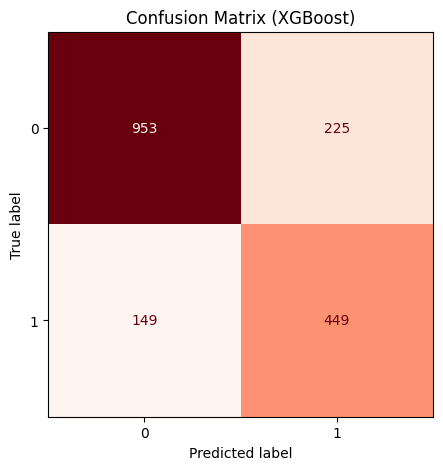

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1178
           1       0.67      0.75      0.71       598

    accuracy                           0.79      1776
   macro avg       0.77      0.78      0.77      1776
weighted avg       0.80      0.79      0.79      1776



['tub_clf_xgb.joblib']

In [166]:
# Scale classifier to boost instances of reported cases
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
recall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, xgb_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

# Best performing model for tubculosis, save it (negligible with thresholding)
joblib.dump(xgb_clf, "tub_clf_xgb.joblib")

Best threshold (Balanced Acc): 0.340
Balanced Acc: 0.7867
Recall(1) / TPR: 0.7475
Recall(0) / TNR: 0.8260
Accuracy: 0.7995, Precision: 0.8050, Recall: 0.7894, F1: 0.8015


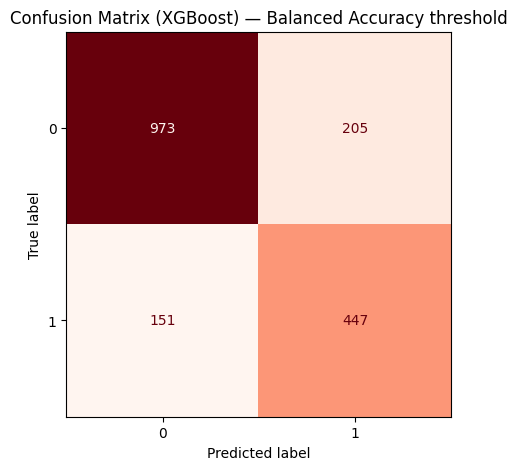

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1178
           1       0.69      0.75      0.72       598

    accuracy                           0.80      1776
   macro avg       0.78      0.79      0.78      1776
weighted avg       0.81      0.80      0.80      1776



In [167]:
# Choosing threshold by best combined average across both classes
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric="logloss",
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# choose threshold by Balanced Accuracy
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_bacc = -1
best_stats = None

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)  # recall for class 1
    tnr = tn / (tn + fp + 1e-12)  # recall for class 0
    bacc = 0.5 * (tpr + tnr)

    if bacc > best_bacc:
        best_bacc = bacc
        best_thr = thr
        best_stats = (tpr, tnr, tp, fn, tn, fp)

print(f"Best threshold (Balanced Acc): {best_thr:.3f}")
print(f"Balanced Acc: {best_bacc:.4f}")
print(f"Recall(1) / TPR: {best_stats[0]:.4f}")
print(f"Recall(0) / TNR: {best_stats[1]:.4f}")

# apply best threshold
xgb_preds = (y_prob >= best_thr).astype(int)

# ---- standard metrics ----
acc = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, pos_label=1, average='weighted')
reccall = recall_score(y_test, xgb_preds, pos_label=1, average='weighted')
f1 = f1_score(y_test, xgb_preds, pos_label=1, average='weighted')
bacc = balanced_accuracy_score(y_test, xgb_preds)

print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Reds", ax=ax, colorbar=False)
plt.title("Confusion Matrix (XGBoost) — Balanced Accuracy threshold")
plt.show()

print("Classification Report:")
print(classification_report(y_test, xgb_preds))

Accuracy: 0.8068693693693694, Precision: 0.8047667631000964, Recall: 0.8068693693693694, F1: 0.8055539152105676
Balanced Accuracy: 0.7774


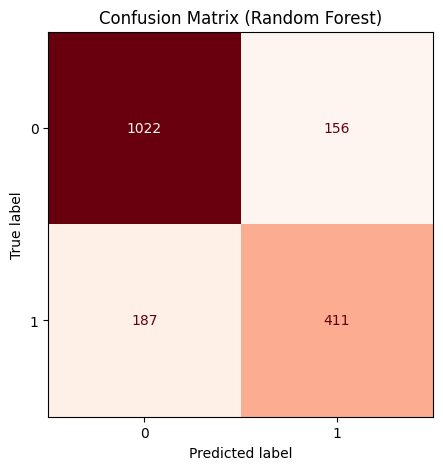

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1178
           1       0.72      0.69      0.71       598

    accuracy                           0.81      1776
   macro avg       0.79      0.78      0.78      1776
weighted avg       0.80      0.81      0.81      1776



In [168]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight={0: 1, 1: (neg / pos) * .5}
)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted')
recall = recall_score(y_test, rf_preds, average='weighted')
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, rf_preds):.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

# Plot it
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Reds', ax=ax, colorbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.show()

print("Classification Report:")
print(classification_report(y_test, rf_preds))

In [169]:
# Regression models -> all cases, there is enough support

df_tub_lin = df_tub.copy()
df_tub_lin = df_tub_lin.sort_values(
    ["Reporting Area norm", "Current MMWR Year", "MMWR WEEK"]
).reset_index(drop=True)

df_tub_lin["t_idx"] = df_tub_lin.groupby("Reporting Area norm").cumcount()
df_tub_lin["t_len"] = df_tub_lin.groupby("Reporting Area norm")["t_idx"].transform("max") + 1

df_tub_lin["is_train"] = df_tub_lin["t_idx"] < (0.8 * df_tub_lin["t_len"])

train_df = df_tub_lin[df_tub_lin["is_train"]].copy()
test_df  = df_tub_lin[~df_tub_lin["is_train"]].copy()

y_train = train_df["Current week"].astype(float)
y_test  = test_df["Current week"].astype(float)

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

RMSE: 1.5359
R²: 0.3747
RSS: 4189.30
TSS: 6699.29
ESS: 2462.46


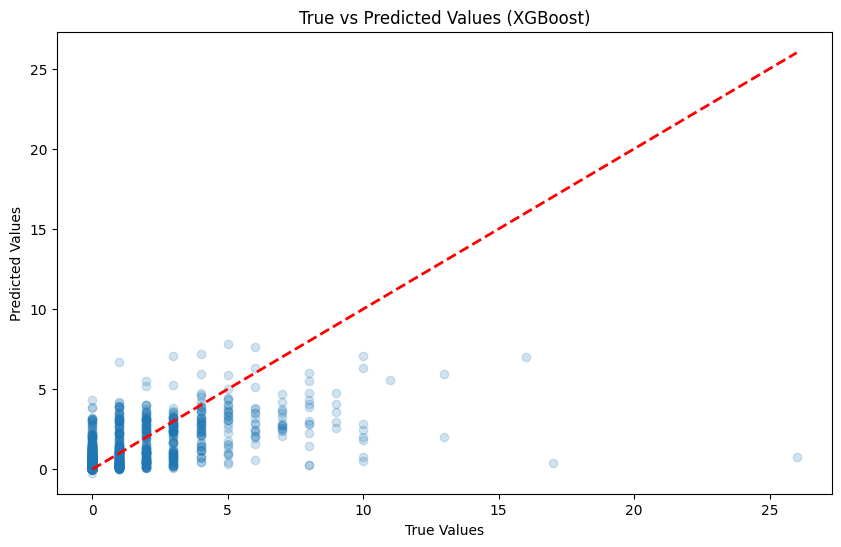

In [170]:
# XGBoost Regressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# RSS, TSS, ESS
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_xgb) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_xgb - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

RMSE: 1.5151
R²: 0.3914
RSS: 4076.93
TSS: 6699.29
ESS: 2567.09


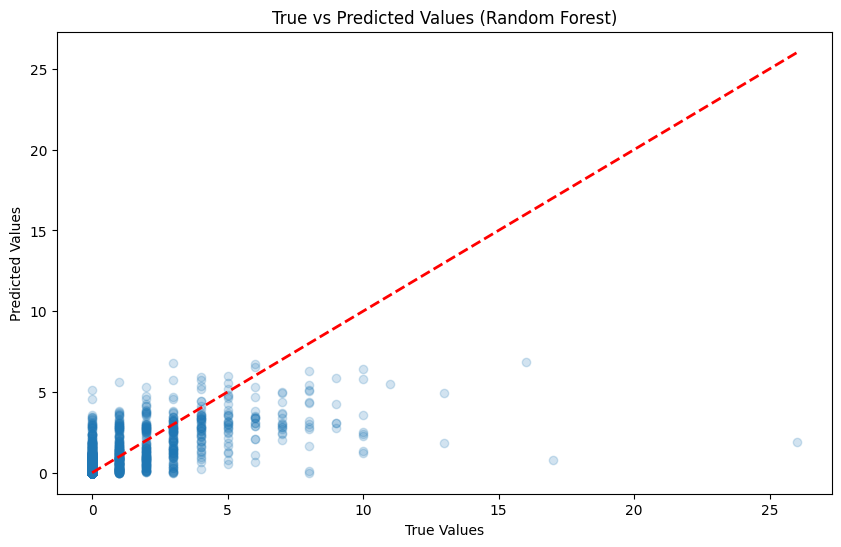

['tub_lin_rf.joblib']

In [171]:
# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Best performing model for tuberculosis, save it
joblib.dump(rf, "tub_lin_rf.joblib")

alpha= 0.1: MAE=751851443612820.625, RMSE=118.826
alpha= 0.5: MAE=751851443612820.625, RMSE=118.761
alpha= 1.0: MAE=751851443612820.625, RMSE=118.682
alpha= 2.0: MAE=751851443612820.625, RMSE=118.527
alpha= 5.0: MAE=751851443612820.625, RMSE=118.082
alpha=10.0: MAE=751851443612820.625, RMSE=117.393
RMSE: 1.5151
R²: 0.3914
RSS: 4076.93
TSS: 6699.29
ESS: 2567.09


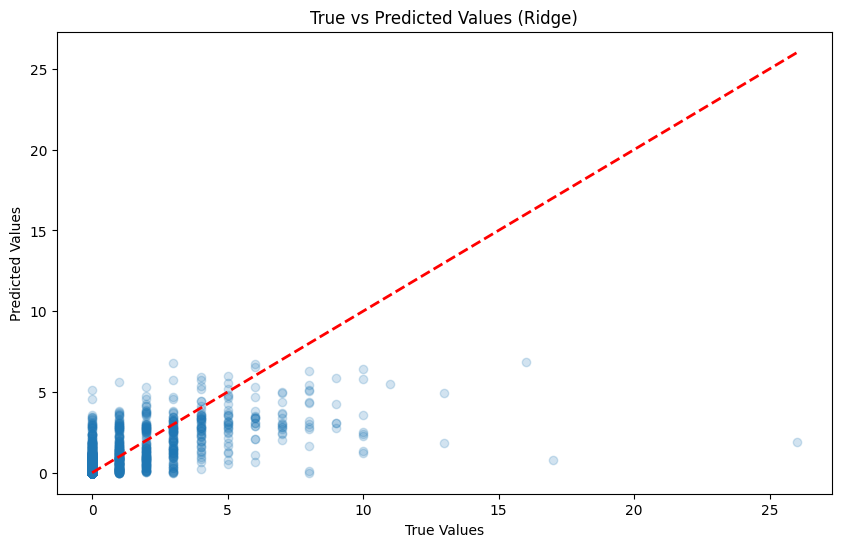

In [172]:
# Ridge Regressor

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

ridge = Ridge(alpha=0.1, random_state=42)
ridge.fit(X_train_s, y_train)
y_pred = np.expm1(ridge.predict(X_test_s))
rmse = sqrt(mean_squared_error(y_test, y_pred))
best_avg = rmse
best_alpha = 0.1
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_s, y_train)
    y_pred = np.expm1(ridge.predict(X_test_s))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"alpha={alpha:>4}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    avg = rmse
    if (avg < best_avg):
      best_avg = avg
      best_alpha = alpha

ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train_s, y_train)

y_pred = ridge.predict(X_test_s)
y_pred = (y_pred).clip(min=1)

# Evaluate performance
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# RSS, TSS, ESS (same as before)
y_mean = np.mean(y_test)
rss = np.sum((y_test - y_pred_rf) ** 2)
tss = np.sum((y_test - y_mean) ** 2)
ess = np.sum((y_pred_rf - y_mean) ** 2)
print(f"RSS: {rss:.2f}")
print(f"TSS: {tss:.2f}")
print(f"ESS: {ess:.2f}")

# --- True vs Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linestyle="--", linewidth=2
)
plt.title("True vs Predicted Values (Ridge)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [173]:
# Viral hemorrhagic fevers
df_vir = df[df["Disease_group"] == 'Viral hemorrhagic fevers'].copy()
df_vir = df_vir.sort_values(["Reporting Area norm", "year", "week"])
df_vir = df_vir.dropna()
df_vir = df_vir.reset_index(drop=True)
df_vir

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_spring,season_summer,season_fall,cases_prev,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Viral hemorrhagic fevers,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
1,Viral hemorrhagic fevers,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
2,Viral hemorrhagic fevers,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
3,Viral hemorrhagic fevers,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
4,Viral hemorrhagic fevers,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Viral hemorrhagic fevers,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9020,Viral hemorrhagic fevers,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9021,Viral hemorrhagic fevers,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9022,Viral hemorrhagic fevers,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591


In [174]:
total_rows = len(df_vir)
positive_rows = df_vir["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

# No positive viral hemorrhagic fevers move on

Total state-weeks: 9024
Positive state-weeks: 0
Percent positive: 0.000%


In [175]:
# Zika virus disease
df_zik = df[df["Disease_group"] == 'Zika virus disease'].copy()
df_zik = df_zik.sort_values(["Reporting Area norm", "year", "week"])
df_zik = df_zik.dropna()
df_zik = df_zik.reset_index(drop=True)
df_zik

,Disease_group,Reporting Area norm,Current MMWR Year,MMWR WEEK,Current week,current_week_reported,lag_1,lag_2,lag_3,lag_4,...,season_spring,season_summer,season_fall,cases_prev,neighbor_cases_sum,neighbor_cases_mean,neighbor_cases_max,neighbor_states_reporting,log_population,log_density
0,Zika virus disease,Alabama,2022,17,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
1,Zika virus disease,Alabama,2022,18,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
2,Zika virus disease,Alabama,2022,19,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
3,Zika virus disease,Alabama,2022,20,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
4,Zika virus disease,Alabama,2022,21,0.0,0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0,15.439699,4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,Zika virus disease,Wyoming,2025,45,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9020,Zika virus disease,Wyoming,2025,46,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9021,Zika virus disease,Wyoming,2025,47,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591
9022,Zika virus disease,Wyoming,2025,48,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0,13.277756,1.94591


In [176]:
total_rows = len(df_zik)
positive_rows = df_zik["current_week_reported"].sum()

print(f"Total state-weeks: {total_rows}")
print(f"Positive state-weeks: {positive_rows}")
print(f"Percent positive: {positive_rows / total_rows:.3%}")

# Not enough support to make a classifier

Total state-weeks: 9024
Positive state-weeks: 4
Percent positive: 0.044%
